# College Selectivity Data Project
## Comparing attributes of colleges to their selectivity status

Thomas Knickerbocker

### Import libraries, load data:

In [ ]:
import urllib.request
import io
import pandas as pd
import numpy as np
url = "http://motioncore-umh.cs.umn.edu/4980/college.csv"
data = urllib.request.urlopen(url)
csv_bytes = data.read()
csv_string = csv_bytes.decode("utf8") #TODO: it's bad practice to assume the data is utf8 formated
csv_data = io.StringIO(csv_string) #Padas expects CSV from a file buffer, not a raw string
df = pd.read_csv(csv_data)
df["Selective"] = df["Top10perc"] > 50

In [ ]:
# Visualize data length
df["Selective"]

0      False
1      False
2      False
3       True
4      False
       ...  
772    False
773    False
774    False
775     True
776    False
Name: Selective, Length: 777, dtype: bool

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)

In [ ]:
# sns.pairplot(df)
# perceived most important predictors: Expend, perc.alumni, PhD, Grad.Rate
df2 = pd.DataFrame(data, columns=['Expenditures/Student', 'percentageAlumni', 'Fac PhD Rate', 'Graduation Rate'])
df2['Expenditures/Student'] = df['Expend']
df2['percentageAlumni'] = df['perc.alumni']
df2['Fac PhD Rate'] = df['PhD']
df2['Graduation Rate'] = df['Grad.Rate']
df2['selective'] = df['Selective']


### Pairplot of selectivity next to other attributes:

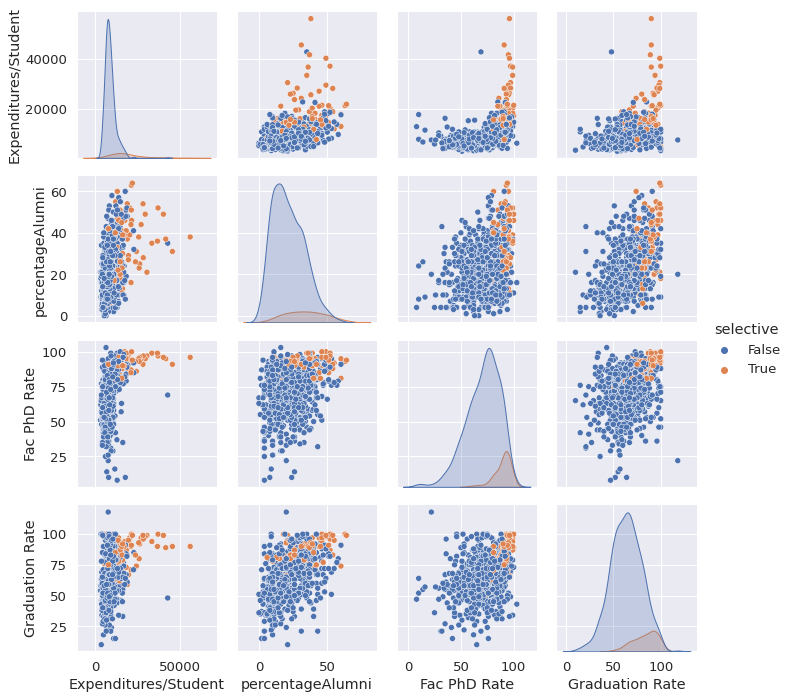

In [ ]:
# Pairplot selectivity next to other data metrics
sns.pairplot(df2, hue='selective')

### Normalize data, make KNN functions

In [ ]:
from matplotlib.colors import ListedColormap
a = df["Grad.Rate"]
b = df["PhD"]

# Data reduction: using 2 metrics alone for prediction
gradMin = np.min(a)
phdMin = np.min(b)
gradMax = np.max(a)
phdMax = np.max(b)
gradRange = gradMax-gradMin
phdRange = phdMax-phdMin

normalizedGrad = (df["Grad.Rate"] - gradMin) 
normalizedGrad = (normalizedGrad/gradRange)
normalizedPhD = (df["PhD"] - phdMin) 
normalizedPhD = (normalizedPhD/phdRange)

features = [normalizedGrad, normalizedPhD]
features = np.swapaxes(features,0,1)
# features2 = df[["Grad.Rate", "PhD"]]
label = df['Selective']
label = label
features = np.array(features)

label = label.to_numpy()
np.set_printoptions(suppress=True)

In [ ]:
from matplotlib.cbook import index_of
from numpy.core.fromnumeric import searchsorted
import sys
def knn_classify_sample(training_set, training_labels, new_example, k):
  dists = np.array([np.sum( (t-new_example)**2) for t in training_set])
  resArr = np.zeros(k)
  # put classifications of k closest samples into resArr
  for i in range(0, k):
    nearest = dists.argmin()
    dists[nearest] = 9999 # pretty cheap, I know.
    resArr[i] = training_labels[nearest]
  # return most frequent value in resArr
  resArr = np.asarray(resArr, dtype = 'int')
  res = np.bincount(resArr).argmax()
  return res

In [ ]:
# SHOULD return array of correct/incorrect statuses (result), 
def knn_classify(train_data, train_features, test_features, k):
  num_result = test_features[:,0].size
  result = np.ones(num_result)
  for i in range(0,num_result):
    result[i] = knn_classify_sample(train_data[:,0:2], train_features, test_features[i], k)
  return result

In [58]:
def train_test_split(X,y,test_size):
  numRows = y.size                     #number or rows in the entire dataset
  splitPoint = int(test_size*numRows)  #the row index test_size% of the way through
  p = np.random.permutation(numRows)   #array for shuffling data
  X = X[p]
  y = y[p]

  #Training data array
  X_train = X[:splitPoint]  # training features
  y_train = y[:splitPoint]  # training labels
  
  #Testing data array
  X_test = X[splitPoint:]  # testing features
  y_test = y[splitPoint:] # testing labels

  return X_train, X_test, y_train, y_test

In [ ]:
# Skewed version of train_test_split that puts only one class in the training data
# For variables in this notebook only
def devious_train_test_split(X,y,test_size,preferredSelectivity=True):
  # Labels:
  labels = (y==preferredSelectivity)
  sel = y[labels]
  nonSel = y[~labels]

  # Features:
  selFeatures = X[labels]
  nonSelFeatures = X[~labels]
  if(preferredSelectivity):
    numRows = selFeatures.size
  else:
    numRows = nonSelFeatures.size
  splitPoint = int(test_size*numRows)

  # Splitting train, test arrays
  xTrain = selFeatures[:splitPoint]
  yTrain = sel[:splitPoint]
  xTest = selFeatures[splitPoint:] # rest of select features
  yTest = sel[splitPoint:]

  # Combine data for testing arrays:
  xTest = np.append(xTest, nonSelFeatures, axis=0)
  yTest = np.append(yTest, nonSel, axis=0)

  # Shuffling arrays & returning
  p = np.random.permutation(yTrain.size)
  xTrain = xTrain[p]
  yTrain = yTrain[p]
  p = np.random.permutation(yTest.size)
  xTest = xTest[p]
  yTest = yTest[p]
  return xTrain, xTest, yTrain, yTest

In [ ]:
def analyzeKNN(classify, X_train, y_train, X_test, y_test, k, testing=True):
  TP, TN, FP, FN = 0, 0, 0, 0;
  if(testing):
    pred = classify(X_train, y_train, X_test, k)
    correct_pred = (pred == y_test) # 1 = classifier chose correctly, 0 = incorrectly 
    # Get count of TP, TN, FP, FN:
    for i in range(0, pred.size): 
      if pred[i]==1 and y_test[i]==1:
        TP+=1
      elif pred[i]==0 and y_test[i]==1:
        FN+=1
      elif pred[i]==1 and y_test[i]==0:
        FP+=1
      else:
        TN+=1
    total_preds = y_test.size

  else:
    pred = classify(X_train, y_train, X_train, k)
    correct_pred = (pred == y_train) # 1 = classifier chose correctly, 0 = incorrectly 
    # Get count of TP, TN, FP, FN:
    for i in range(0, pred.size): 
      if pred[i]==1 and y_train[i]==1:
        TP+=1
      elif pred[i]==0 and y_train[i]==1:
        FN+=1
      elif pred[i]==1 and y_train[i]==0:
        FP+=1
      else:
        TN+=1
    total_preds = y_train.size


  print("TP, TN, FP, FN (raw post-testing values): ", TP, TN, FP, FN)
  # Checks added because /0 happesn with devious data
  if(TP+FP > 0):
    precision = TP/(TP+FP)
  else:
    precision=0
  if (TP+FN>0):
    recall = TP/(TP+FN)
  else:
    recall = 0
  accuracy = correct_pred.sum()/total_preds
  if(2*TP + FP + FN > 0):
    f1 = 2*TP/(2*TP + FP + FN)
  else:
    f1=0
  return precision, recall, accuracy, f1

In [96]:
# Regular:
X_train, X_test, y_train, y_test = train_test_split(features,label,0.5)
# Skewed:
# X_train, X_test, y_train, y_test = devious_train_test_split(features,label,0.33, True)

### Show performance metrics of our two classifiers:

In [99]:
# Low K-value Classifier:
print("TRAINING DATA:")
precision, recall, accuracy, f1 = analyzeKNN(knn_classify, X_train, y_train, X_test, y_test, 3, False) 
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("F1: ", f1)

print("TESTING DATA:")
precision, recall, accuracy, f1 = analyzeKNN(knn_classify, X_train, y_train, X_test, y_test, 3, True) 
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("F1: ", f1)

TRAINING DATA:
TP, TN, FP, FN (raw post-testing values):  17 351 3 17
Precision:  0.85
Recall:  0.5
Accuracy:  0.9484536082474226
F1:  0.6296296296296297
TESTING DATA:
TP, TN, FP, FN (raw post-testing values):  21 315 30 23
Precision:  0.4117647058823529
Recall:  0.4772727272727273
Accuracy:  0.8637532133676092
F1:  0.4421052631578947


In [100]:
# High K-value Classifier:
print("TRAINING DATA:")
precision, recall, accuracy, f1 = analyzeKNN(knn_classify, X_train, y_train, X_test, y_test, 10, False) 
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("F1: ", f1)

print("TESTING DATA:")
precision, recall, accuracy, f1 = analyzeKNN(knn_classify, X_train, y_train, X_test, y_test, 10, True) 
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("F1: ", f1)

TRAINING DATA:
TP, TN, FP, FN (raw post-testing values):  10 352 2 24
Precision:  0.8333333333333334
Recall:  0.29411764705882354
Accuracy:  0.9329896907216495
F1:  0.43478260869565216
TESTING DATA:
TP, TN, FP, FN (raw post-testing values):  18 340 5 26
Precision:  0.782608695652174
Recall:  0.4090909090909091
Accuracy:  0.9203084832904884
F1:  0.5373134328358209


In [64]:
# No schools are selective classifier (uses a k so high that the majority class, non-selective, is always chosen):
print("TRAINING DATA:")
precision, recall, accuracy, f1 = analyzeKNN(knn_classify, X_train, y_train, X_test, y_test, 80
, False) 
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("F1: ", f1)

print("TESTING DATA:")
precision, recall, accuracy, f1 = analyzeKNN(knn_classify, X_train, y_train, X_test, y_test, 80
, True) 
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("F1: ", f1)

TRAINING DATA:
TP, TN, FP, FN (raw post-testing values):  0 349 0 39
Precision:  0
Recall:  0.0
Accuracy:  0.8994845360824743
F1:  0.0
TESTING DATA:
TP, TN, FP, FN (raw post-testing values):  0 350 0 39
Precision:  0
Recall:  0.0
Accuracy:  0.8997429305912596
F1:  0.0


In [65]:
# All schools are selective classifier (uses training data containing only selective schools):

# Function splits data so all training points meet selection criteria of last boolean (True=Selective), and all remaining data goes into testing category:
X_train, X_test, y_train, y_test = devious_train_test_split(features,label,0.33, True)

print("TRAINING DATA:")
precision, recall, accuracy, f1 = analyzeKNN(knn_classify, X_train, y_train, X_test, y_test, 10, False) 

print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("F1: ", f1)

print("TESTING DATA:")
precision, recall, accuracy, f1 = analyzeKNN(knn_classify, X_train, y_train, X_test, y_test, 10, True) 

print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("F1: ", f1)

TRAINING DATA:
TP, TN, FP, FN (raw post-testing values):  51 0 0 0
Precision:  1.0
Recall:  1.0
Accuracy:  1.0
F1:  1.0
TESTING DATA:
TP, TN, FP, FN (raw post-testing values):  27 0 699 0
Precision:  0.0371900826446281
Recall:  1.0
Accuracy:  0.0371900826446281
F1:  0.07171314741035857


### Predicing some points:

In [67]:
X_train, X_test, y_train, y_test = train_test_split(features,label,0.5)
newGrad =( 78 - gradMin) / gradRange
newPHD = ( 84 - phdMin) / phdRange
newData = [newGrad, newPHD]
x = knn_classify_sample(X_train, y_train, newData, 10)
x

0

In [90]:
X_train, X_test, y_train, y_test = train_test_split(features,label,0.5)
newData = [newGrad*1.16, newPHD*1.16] # modified
x = knn_classify_sample(X_train, y_train, newData, 10)
x

1